In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
for class_name in Base.classes.keys():
    print(class_name)

# Optionally, to get a reference to a specific class and work with it
# MyClass = Base.classes.some_table_name

measurement
station


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
from sqlalchemy import inspect

inspector = inspect(measurement)

# Iterate through all columns in the User table/class
for column in inspector.c:
    print(f"Name: {column.name}, Type: {column.type}")


Name: id, Type: INTEGER
Name: station, Type: TEXT
Name: date, Type: TEXT
Name: prcp, Type: FLOAT
Name: tobs, Type: FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

if most_recent_date:
    print(f"The most recent date is: {most_recent_date[0]}")
else:
    print("No dates found in the database.")

The most recent date is: 2017-08-23


Most recent date: 2017-08-23
Date one year ago: 2016-08-23


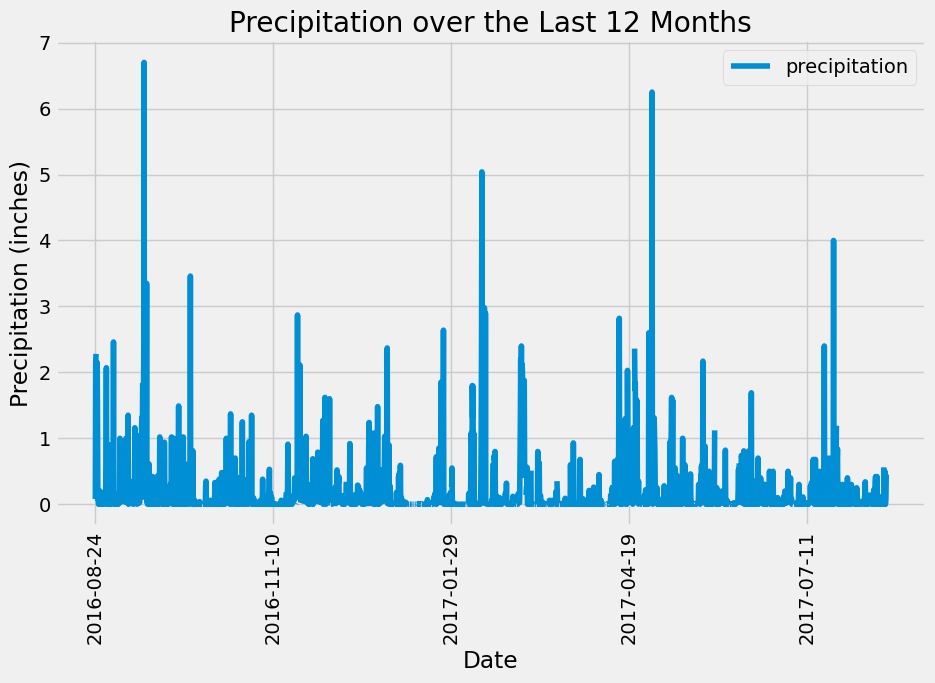

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(func.max(measurement.date)).scalar()
print(f"Most recent date: {recent_date}")
# Calculate the date one year from the last date in data set.
# Convert the most recent date string to a datetime object
from datetime import datetime, timedelta
recent_date_obj = datetime.strptime(recent_date, "%Y-%m-%d")

# Calculate the date one year before the most recent date
year_ago_date = recent_date_obj - timedelta(days=365)
print(f"Date one year ago: {year_ago_date.date()}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago_date).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Set the date column as the DataFrame index
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation over the Last 12 Months", figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation='vertical')
plt.legend(loc='upper right')
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()

# Print the summary statistics
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station.distinct())).scalar()

print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to find the most active stations
most_active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()

# Print the list of stations and their counts
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [18]:
from sqlalchemy import func
most_active_station_id = 'USC00519281'
# Assuming 'most_active_station_id' holds the ID of the most active station
# This should be determined from your previous query

# Query to find the lowest temperature from the most active station
lowest_temp = session.query(func.min(measurement.tobs))\
    .filter(measurement.station == most_active_station_id)\
    .scalar()

# Query to find the highest temperature from the most active station
highest_temp = session.query(func.max(measurement.tobs))\
    .filter(measurement.station == most_active_station_id)\
    .scalar()

# Query to find the average temperature from the most active station
average_temp = session.query(func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station_id)\
    .scalar()

# Print the results
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp:.2f}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.date, func.avg(measurement.tobs)]

# Calculate the most recent date and the date one year ago from the most recent date
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Convert one_year_ago to string format for the query
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Example to filter by May (05), adjust '%m' == '05' as needed
temperature_averages = session.query(*sel)\
    .filter(measurement.station == most_active_station_id)\
    .filter(func.strftime("%Y-%m-%d", measurement.date) >= one_year_ago_str)\
    .group_by(measurement.date)\
    .order_by(measurement.date).all()
# Print the results
print(f"Most recent date: {most_recent_date}")
print(f"Temperature Avgs: {temperature_averages}")
#rint(f"Select values: {sel}")


Most recent date: 2017-08-23 00:00:00
Temperature Avgs: [('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0), ('2016-08-28', 73.0), ('2016-08-29', 78.0), ('2016-08-30', 77.0), ('2016-08-31', 78.0), ('2016-09-01', 80.0), ('2016-09-02', 80.0), ('2016-09-03', 78.0), ('2016-09-04', 78.0), ('2016-09-05', 78.0), ('2016-09-06', 73.0), ('2016-09-07', 74.0), ('2016-09-08', 80.0), ('2016-09-09', 79.0), ('2016-09-10', 77.0), ('2016-09-11', 80.0), ('2016-09-12', 76.0), ('2016-09-13', 79.0), ('2016-09-14', 75.0), ('2016-09-15', 79.0), ('2016-09-16', 78.0), ('2016-09-17', 79.0), ('2016-09-18', 78.0), ('2016-09-19', 78.0), ('2016-09-20', 76.0), ('2016-09-21', 74.0), ('2016-09-22', 77.0), ('2016-09-23', 78.0), ('2016-09-24', 79.0), ('2016-09-25', 79.0), ('2016-09-26', 77.0), ('2016-09-27', 80.0), ('2016-09-28', 78.0), ('2016-09-29', 78.0), ('2016-09-30', 78.0), ('2016-10-01', 77.0), ('2016-10-02', 79.0), ('2016-10-03', 79.0), ('2016-10-04', 79.0

In [27]:

# Convert to DataFrame
df_temperature_averages = pd.DataFrame(temperature_averages, columns=['Date', 'AvgTemperature'])

# Display the DataFrame to verify its structure
print(df_temperature_averages.head())

# Export to CSV
df_temperature_averages.to_csv('Resources/temperature_averages.csv', index=False)

         Date  AvgTemperature
0  2016-08-23            77.0
1  2016-08-24            77.0
2  2016-08-25            80.0
3  2016-08-26            80.0
4  2016-08-27            75.0


# Close Session

In [16]:
# Close Session
session.close()